In [1]:
import numpy as np 
import torch.nn as nn
import torch
from torchvision.transforms import transforms
from torchvision import datasets,models
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [2]:
batch_size = 20
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])
train_data = datasets.FashionMNIST(root = 'data_FNIST',download = True,train = True,
                           transform =transform)
test_data = datasets.FashionMNIST(root = 'data_FNIST', download = False,train = False,
                          transform = transform)

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler as SRS
valid_size = 0.2
num_train = len(train_data)
indices  = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_index,valid_index = indices[split:],indices[:split]

train_sample = SRS(train_index)
valid_sample = SRS(valid_index)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, sampler = train_sample)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, sampler = valid_sample)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size)

In [4]:
classes = ['T-shirt',
           'Trouser',
            'Pullover',
            'Dress',
            'Coat',
            'Sandal',
            'Shirt',
            'Sneaker',
            'Bag',
            'Ankle Boot']

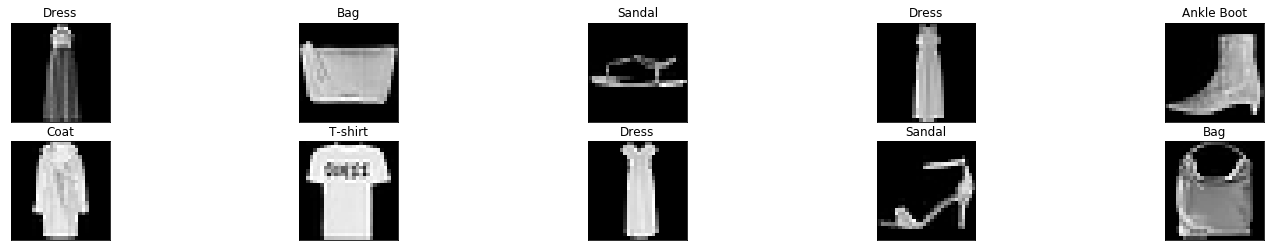

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
df = next(iter(train_loader))
images,labels = df
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[i][0]),cmap='gray')
    ax.set_title(classes[labels[i]])

In [6]:
images.shape

torch.Size([20, 1, 28, 28])

In [7]:
import torch.nn as nn
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.con1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.con2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(p = 0.25)
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.con1(x)
        out = self.con2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model=ConvNet()
print(model)
model.cuda()

ConvNet(
  (con1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.25)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


ConvNet(
  (con1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.25)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01 )

In [9]:
n_epochs = 20
valid_loss_min = 0 
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data,target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    model.eval()
    for data, target in valid_loader:
        data,target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset) 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.522929 	Validation Loss: 0.088241
Epoch: 2 	Training Loss: 0.336413 	Validation Loss: 0.073625
Epoch: 3 	Training Loss: 0.290872 	Validation Loss: 0.065359
Epoch: 4 	Training Loss: 0.267314 	Validation Loss: 0.060635
Epoch: 5 	Training Loss: 0.247724 	Validation Loss: 0.057742
Epoch: 6 	Training Loss: 0.231102 	Validation Loss: 0.055995
Epoch: 7 	Training Loss: 0.221783 	Validation Loss: 0.053170
Epoch: 8 	Training Loss: 0.211489 	Validation Loss: 0.051942
Epoch: 9 	Training Loss: 0.202344 	Validation Loss: 0.051476
Epoch: 10 	Training Loss: 0.194792 	Validation Loss: 0.049864
Epoch: 11 	Training Loss: 0.187745 	Validation Loss: 0.048257
Epoch: 12 	Training Loss: 0.181984 	Validation Loss: 0.048986
Epoch: 13 	Training Loss: 0.177859 	Validation Loss: 0.048842
Epoch: 14 	Training Loss: 0.171232 	Validation Loss: 0.047771
Epoch: 15 	Training Loss: 0.166590 	Validation Loss: 0.046251
Epoch: 16 	Training Loss: 0.161733 	Validation Loss: 0.044654
Epoch: 17 	Traini

In [17]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
    if train_on_gpu:
        data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(20):
        label = pred.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        #classes[label.cpu().numpy()]
for i in range(10):
    
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt : 90 %
Accuracy of Trouser : 99 %
Accuracy of Pullover : 93 %
Accuracy of Dress : 90 %
Accuracy of  Coat : 79 %
Accuracy of Sandal : 98 %
Accuracy of Shirt : 70 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 97 %
Accuracy of Ankle Boot : 98 %
Overall accuaracy:  100.0
